EGRMGMT 590.10 – New Opportunity in Big Data
Spring 2019


# Churn Prediction

Kinjal Sanghvi, MAddhujeet Chandra and Vardayini Sharma

### Acknowledgment
Firstly, we would like express our gratitude to Prof. Dan Yang for her guidance throughout the semester and for the completion of the project. Secondly, We would like to say thanks to Duke University for giving us the opportunity to be a part of the program. Finally, we are grateful to our family and friends for their support. 

### Problem Statement

To predict whether a user will continue or cancel the subscription of KKBox, a leading Asian music subscription service. A small change in churn rate has a significant impact on the profits. This can help derive actionable insights that will help KKBox retain its customer base and maintain profitability. It is said, cost of acquiring new customers is 5 to 10 times that of retaining them. Customer retention is one of the leading problems companies face, irrespective of their product portfolio(i.e. B2B, B2C or a mixture of both). Performing churn analysis would help us identify the risk associated with individual customer/client and take appropriate measures as seen by the company to reduce the churn. Thus, it is an effective tool to device an effective data-driven customer/client retention strategy that would benefit any company

## About the Dataset

KKbox is asia’s leading music streaming service, holding the world’s most comprehensive Asia-Pop music library with over 30 million tracks. The dataset contains four csv which include the user_logs, transactions, member’s information, train labels. 
User_logs and transactions contain 329,000,000 and 21,547,746 data points respectively. The dataset was cleaned to finally give us 66 features with 58,293,180 data points.

+ Dealing with multiple entries of the same member in transaction and user_logs 

+ Ensure that important historical information is not lost while aggregation

+ Our data is highly imbalanced

+ Extremely heavy datasets that contain 320 million data points

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

User logs has the logs for the activities of all the users on the KKBox app. User_logs has 329 million rows. Due to the large size of the dataset, user_logs.csv couldn't be loaded into a pandas dataframe. We used Dask to read the file and compute the aggregates of the following features for each user:
- **num_25**: Number of songs for which user listened to 25% of the song
- **num_50**: Number of songs for which user listened to 50% of the song
- **num_75**: Number of songs for which user listened to 75% of the song
- **num_985**: Number of songs for which user listened to 98.5% of the song
- **num_100**: Number of songs for which user listened to 100% of the song
- **num_unq**: Number of unique songs the user listened to
- **total_secs**: Total number of seconds the user listened to music on KKBox

In [ ]:
import dask
import dask.dataframe as dd

user = dd.read_csv('data/user_logs.csv')
user = user.groupby('msno')[['num_25','num_50','num_75','num_985','num_100','num_unq','total_secs']].sum().compute()
user.to_csv("new_user_log.csv")

In [2]:
members=pd.read_csv("data/members_v3.csv")

In [3]:
logs=pd.read_csv("data/new_user_log.csv")


In [4]:
train=pd.read_csv("data/train.csv")

In [5]:
transactions=pd.read_csv("data/transactions.csv")

## Cleaning Data and Exploratory Data Analysis

### Train Dataset

In [6]:
train.head()

,msno,is_churn
0,waLDQMmcOu2jLDaV1ddDkgCrB/jl6sD66Xzs0Vqax1Y=,1
1,QA7uiXy8vIbUSPOkCf9RwQ3FsT8jVq2OxDr8zqa7bRQ=,1
2,fGwBva6hikQmTJzrbz/2Ezjm5Cth5jZUNvXigKK2AFA=,1
3,mT5V8rEpa+8wuqi6x0DoVd3H5icMKkE9Prt49UlmK+4=,1
4,XaPhtGLk/5UvvOYHcONTwsnH97P4eGECeq+BARGItRw=,1


In [7]:
train['is_churn']=train['is_churn'].astype('category')
tot=len(train)
print("Total Number of instances: ",tot)

Total Number of instances:  992931


In [8]:
print("Percentage of Subscribed users:",(train.is_churn.value_counts()[0]/tot)*100,"%")

Percentage of Subscribed users: 93.60771292265021 %


In [9]:
print("Percentage of Churned users:",(train.is_churn.value_counts()[1]/tot)*100,"%")

Percentage of Churned users: 6.392287077349786 %


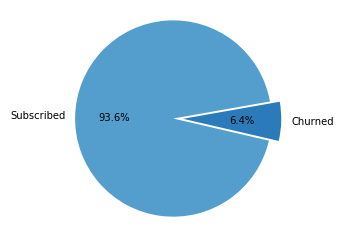

In [10]:
labels = ["Subscribed","Churned"]
sizes = [93.6,6.4]
colors = sns.color_palette("Blues")[-3:-1]
explode = (0.1, 0)  
 
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=10)

plt.axis('equal')
plt.show()



It means only 6.4% of the members are churning. The dataset is imbalanced and we need to overcome this challenge. 

In [11]:
len(pd.unique(train.msno))/tot

1.0

All member id's are unique

------------

### Members dataset

In [12]:
print("Total Number of instances: ",len(members))

Total Number of instances:  6769473


In [13]:
members.head()

,msno,city,bd,gender,registered_via,registration_init_time
0,Rb9UwLQTrxzBVwCB6+bCcSQWZ9JiNLC9dXtM1oEsZA8=,1,0,NaN,11,20110911
1,+tJonkh+O1CA796Fm5X60UMOtB6POHAwPjbTRVl/EuU=,1,0,NaN,7,20110914
2,cV358ssn7a0f7jZOwGNWS07wCKVqxyiImJUX6xcIwKw=,1,0,NaN,11,20110915
3,9bzDeJP6sQodK73K5CBlJ6fgIQzPeLnRl0p5B77XP+g=,1,0,NaN,11,20110915
4,WFLY3s7z4EZsieHCt63XrsdtfTEmJ+2PnnKLH5GY4Tk=,6,32,female,9,20110915


In [14]:
members.isna().any()

msno                      False
city                      False
bd                        False
gender                     True
registered_via            False
registration_init_time    False
dtype: bool

--------

#### Gender

There are NaN values in gender.

In [15]:
members.gender.isnull().sum()

4429505

We can say that these members prefer not to share their gender. Imputing the value 'NT' for people who did not fill in their gender.

In [16]:
members.gender.fillna(value="NT",inplace=True)

In [17]:
members=members.merge(train,on="msno") #adding target variable is_churn to the member dataset

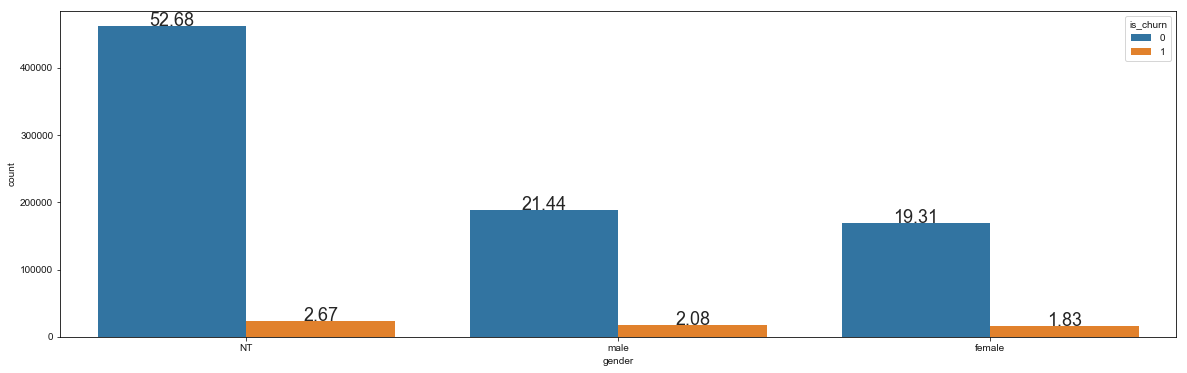

In [18]:
fig,axes = plt.subplots(figsize=(20,6))
ax=sns.countplot(x="gender",hue='is_churn' ,data=members)
sns.set_style("darkgrid")
sns.set(font_scale=1.5)
total = float(len(members))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2,height+3,'{:1.2f}'.format((height/total)*100), ha="center")

plt.show()

As people who did not mention their gender are far more than the ones who mentioned it, we can't say which gender subscribes more to kkbox.

-------------------

#### City:

In [19]:
len(members.city.value_counts())

21

In [20]:
members["city"] =members["city"].astype('category')
members.city.value_counts()

1     455389
13     98281
5      71299
4      47945
15     43356
22     42129
6      26022
14     20167
12     11554
9       9558
11      9036
18      7842
8       7690
10      6533
17      5546
21      5286
3       5089
7       2666
16       956
20       677
19       140
Name: city, dtype: int64

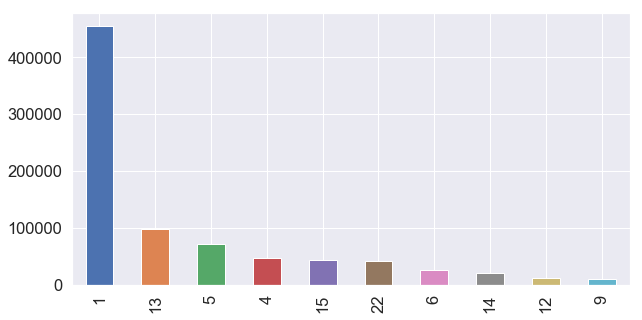

In [21]:
fig,axes = plt.subplots(figsize=(10,5))
plt.set_xlabel="Cities"
ax=members.city.value_counts()[:10].plot(kind='bar')
plt.show()

There are 21 cities in total, most members are from city 1.

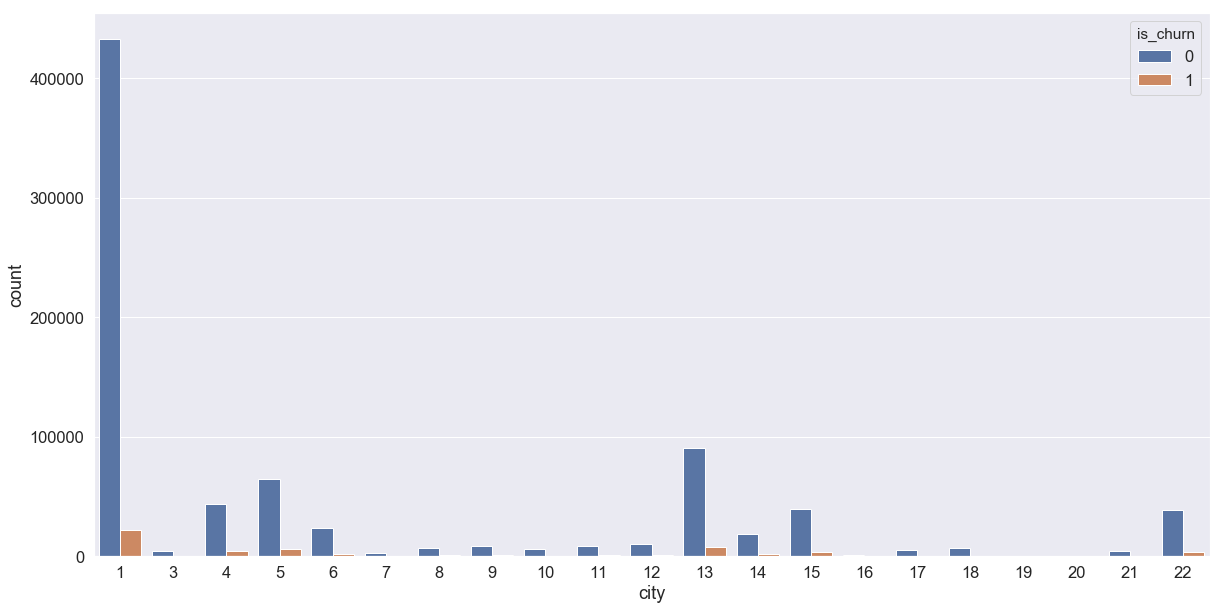

In [22]:
fig,axes = plt.subplots(figsize=(20,10))
ax=sns.countplot(x="city",hue='is_churn' ,data=members)
sns.set(font_scale=1.5)
total = float(len(members))

plt.show()

-----------------------

#### bd is the age

In [23]:
#sns.countplot(y="bd", data=members)
members.bd.max()

2016

In [24]:
members.bd.min()

-3152

A lot of outliers

In [25]:
print("% of negative age values:", (len(members[members.bd<=0])/len(members))*100)

% of negative age values: 55.58420860024557


In [26]:
print("% of age values above 100:",(len(members[members.bd>100])/len(members))*100)

% of age values above 100: 0.052213903718929595


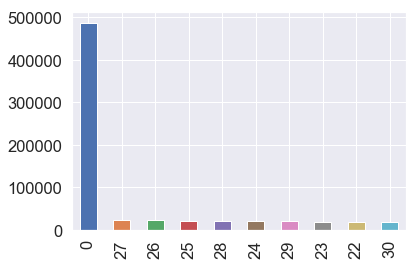

In [27]:
members.bd.value_counts()[:10].plot(kind='bar')
plt.show()

#### As 55% of the members age is zero or less! For ages between 0 and 100, following is the distribution:

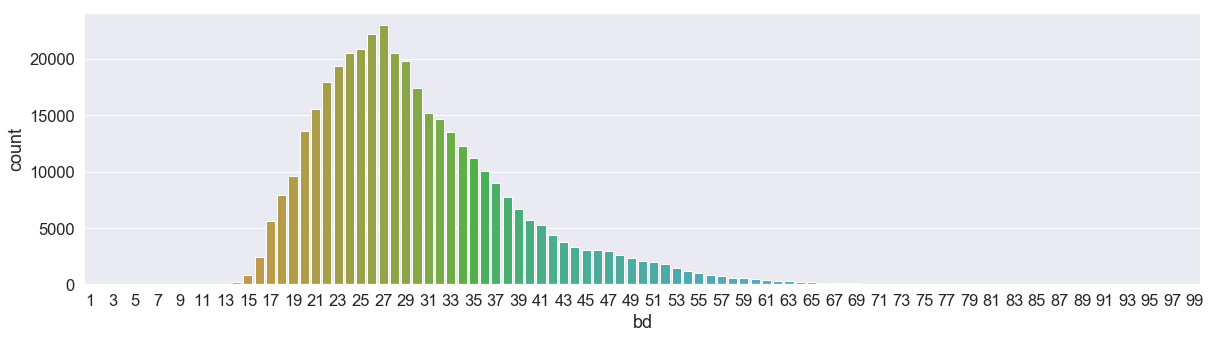

In [28]:
fig,axes = plt.subplots(figsize=(20,5))
ax=sns.countplot(x="bd", data=members[(members.bd>0)&(members.bd<100)])
sns.set(font_scale=1.5)
xticks=ax.xaxis.get_major_ticks()
for i in range(len(xticks)):
    if i%2==1:
        xticks[i].set_visible(False)
plt.show()
#members[(members.bd>0)&(members.bd<100)].bd.value_counts().plot(kind='bar')

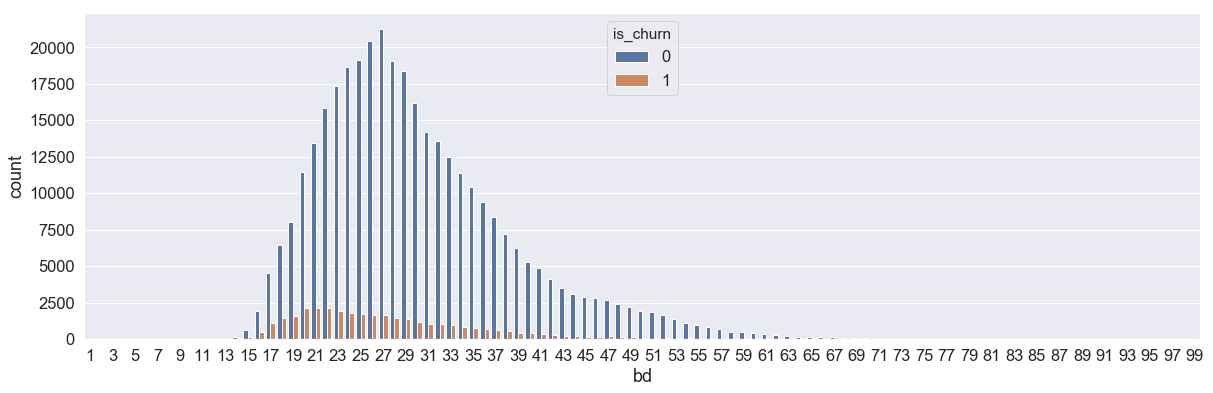

In [29]:
fig,axes = plt.subplots(figsize=(20,6))

ax=sns.countplot(x="bd",hue="is_churn", data=members[(members.bd>0)&(members.bd<100)])
sns.set(font_scale=1.5)
xticks=ax.xaxis.get_major_ticks()
for i in range(len(xticks)):
    if i%2==1:
        xticks[i].set_visible(False)
plt.show()


out of the instances which have valid ages, youngsters have a slightly more tendency to churn.

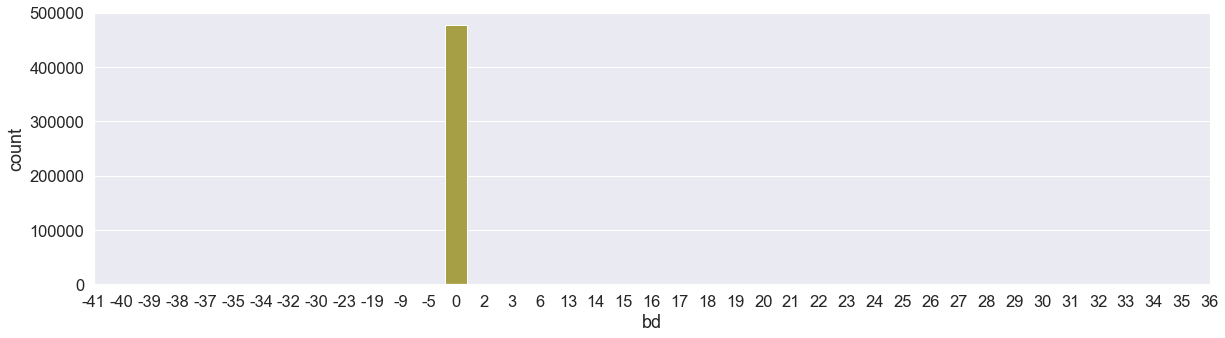

In [30]:
fig,axes = plt.subplots(figsize=(20,5))

ax=sns.countplot(x="bd", data=members[members.gender=='NT'])
ax.set(xlim=(10,50))
plt.show()

Members who did not fill their gender, also filled in their age as zero or was automatically recorded as zero.

---------

#### Registeration Via

In [31]:
members["registered_via"] =members["registered_via"].astype('category')


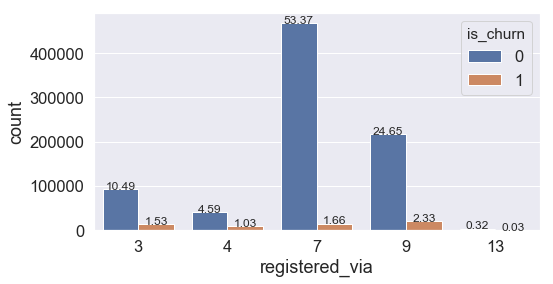

In [32]:
fig,axes = plt.subplots(figsize=(8,4))
ax=sns.countplot(x="registered_via",hue='is_churn' ,data=members)
sns.set(font_scale=1)

total = float(len(members))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2,height+3,'{:1.2f}'.format((height/total)*100), ha="center") 
plt.show()

53% of users used 7 as the medium of registeration. Maximum churn is from type 9.

----------

#### Registeration_init_time
It is the date on which the user registered. Changed it to the datetime format. 

In [33]:
members.registration_init_time = pd.to_datetime(members.registration_init_time,format="%Y%m%d")

In [34]:
members.head()

,msno,city,bd,gender,registered_via,registration_init_time,is_churn
0,+tJonkh+O1CA796Fm5X60UMOtB6POHAwPjbTRVl/EuU=,1,0,NT,7,2011-09-14,0
1,yLkV2gbZ4GLFwqTOXLVHz0VGrMYcgBGgKZ3kj9RiYu8=,4,30,male,9,2011-09-16,0
2,WH5Jq4mgtfUFXh2yz+HrcTXKS4Oess4k4W3qKolAeb0=,5,34,male,9,2011-09-16,1
3,I0yFvqMoNkM8ZNHb617e1RBzIS/YRKemHO7Wj13EtA0=,13,63,male,9,2011-09-18,0
4,OoDwiKZM+ZGr9P3fRivavgOtglTEaNfWJO4KaJcTTts=,1,0,NT,7,2011-09-18,0


-----------

### Transaction Dataset

In [35]:
print("Total Number of instances: ",len(transactions))

Total Number of instances:  21547746


In [36]:
transactions=transactions.merge(train,on="msno")

In [37]:
len(transactions)

15883148

In [38]:
transactions.head()

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,is_churn
0,YyO+tlZtAXYXoZhNr3Vg3+dfVQvrBVGO8j1mfqe4ZHc=,41,30,129,129,1,20150930,20151101,0,0
1,YyO+tlZtAXYXoZhNr3Vg3+dfVQvrBVGO8j1mfqe4ZHc=,41,30,129,129,1,20151031,20151201,0,0
2,YyO+tlZtAXYXoZhNr3Vg3+dfVQvrBVGO8j1mfqe4ZHc=,41,30,129,129,1,20150630,20150801,0,0
3,YyO+tlZtAXYXoZhNr3Vg3+dfVQvrBVGO8j1mfqe4ZHc=,41,30,129,129,1,20150228,20150401,0,0
4,YyO+tlZtAXYXoZhNr3Vg3+dfVQvrBVGO8j1mfqe4ZHc=,41,30,129,129,1,20161130,20170101,0,0


In [39]:
transactions.isna().any()

msno                      False
payment_method_id         False
payment_plan_days         False
plan_list_price           False
actual_amount_paid        False
is_auto_renew             False
transaction_date          False
membership_expire_date    False
is_cancel                 False
is_churn                  False
dtype: bool

It has no NaN values. 

-------

#### Is_cancel:

In [40]:
transactions.is_cancel.value_counts()/len(transactions)

0    0.982623
1    0.017377
Name: is_cancel, dtype: float64

Only 1.7% cancellations. The more number of times a member renews his/her subscription, the more no. of times is_cancel will be 0. This adds to the imbalance

_______________

#### Payment plan days

______________________

There are a lot of different payment plan days. Clubbing them together under different plans according to the website of kkbox. The plans are as followed:
        - 1-7 days is the trial -> 0
        - 30/31 days is monthly -> 1
        - 60 days is 2 months -> 2
        - 90 days is 3 months -> 3
        - 180 days is 6 months  -> 4
        - 365/395/410 days is yearly -> 5
     

In [41]:
transactions.loc[(transactions.payment_plan_days>=0)&(transactions.payment_plan_days<=7),['payment_plan_days']]=0
transactions.loc[(transactions.payment_plan_days>=8)&(transactions.payment_plan_days<=31),['payment_plan_days']]=1
transactions.loc[(transactions.payment_plan_days>=32)&(transactions.payment_plan_days<=60),['payment_plan_days']]=2
transactions.loc[(transactions.payment_plan_days>=61)&(transactions.payment_plan_days<=90),['payment_plan_days']]=3
transactions.loc[(transactions.payment_plan_days>=91)&(transactions.payment_plan_days<=180),['payment_plan_days']]=4
transactions.loc[(transactions.payment_plan_days>=181)&(transactions.payment_plan_days<=456),['payment_plan_days']]=5

Distribution of payment_plan_days:

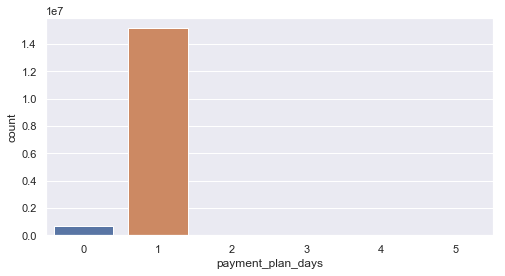

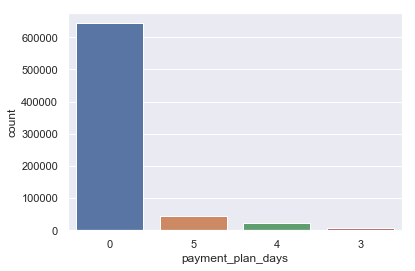

1    15165480
0      644103
5       43179
4       21272
3        6119
2        2995
Name: payment_plan_days, dtype: int64

In [42]:
sns.set_style("darkgrid")
fig,axes = plt.subplots(figsize=(8,4))
ax=sns.countplot(x="payment_plan_days" ,data=transactions)
plt.show()
ax=sns.countplot(x="payment_plan_days", data=transactions, order=transactions.payment_plan_days.value_counts().iloc[1:5].index)
plt.show()
transactions.payment_plan_days.value_counts()

Most number of people go for the monthly plan.

_________

#### There are 38 payment methods available. Following are the 10 most preferred methods:

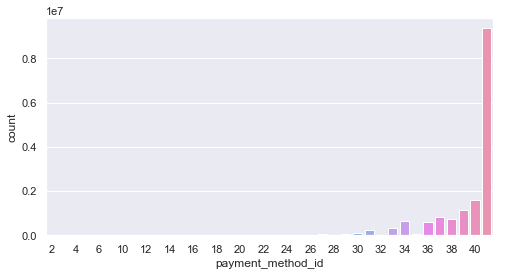

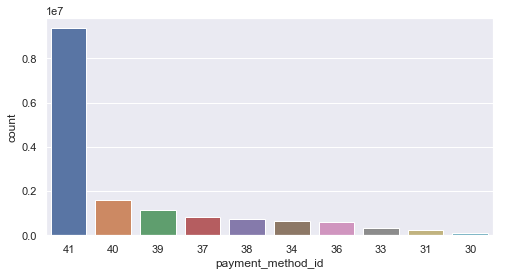

In [43]:
sns.set_style("darkgrid")
fig,axes = plt.subplots(figsize=(8,4))
ax=sns.countplot(x="payment_method_id" ,data=transactions)
xticks=ax.xaxis.get_major_ticks()
for i in range(len(xticks)):
    if i%2==1:
        xticks[i].set_visible(False)
plt.show()
fig,axes = plt.subplots(figsize=(8,4))
ax=sns.countplot(x="payment_method_id" ,data=transactions, order=transactions.payment_method_id.value_counts().iloc[0:10].index)

----------------

#### PriceDiff:

Calculating difference between list price and actual price paid to gauge the number of customers who got a discount and the number who paid extra. KKbox allows user to paid extra that can be carry forwarded for the next transaction.

In [44]:
transactions['PriceDiff']=transactions.plan_list_price - transactions.actual_amount_paid

______________________

#### Creating a binary variable for Discount and Extrapaid:

In [45]:
transactions['Discount']=0
transactions['ExtraPaid']=0
transactions.loc[(transactions.PriceDiff>0),['Discount']]=1
transactions.loc[(transactions.PriceDiff<=0),['Discount']]=0
transactions.loc[(transactions.PriceDiff<0),['ExtraPaid']]=1
transactions.loc[(transactions.PriceDiff>=0),['ExtraPaid']]=0


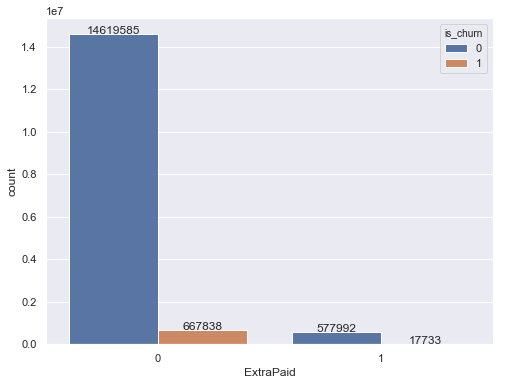

In [46]:
fig,axes = plt.subplots(figsize=(8,6))
ax=sns.countplot(x="ExtraPaid",hue="is_churn" ,data=transactions)
total = float(len(transactions))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2,height,'{:1d}'.format(height), ha="center") 

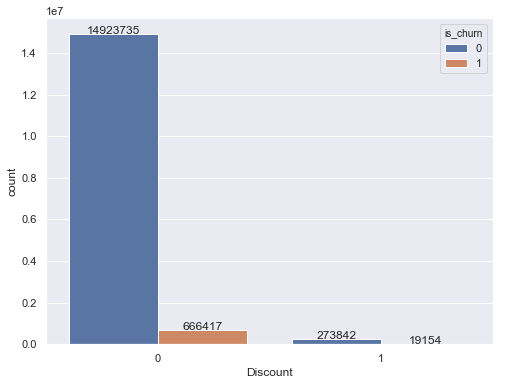

In [47]:
fig,axes = plt.subplots(figsize=(8,6))
ax=sns.countplot(x="Discount" ,hue="is_churn",data=transactions)
total = float(len(transactions))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2,height,'{:1d}'.format(height), ha="center") 


_________________________

#### membership_expire_date and transaction_date: 

Changing types of membership_expire_date and transaction_date to Datetime:

In [48]:
transactions.membership_expire_date=pd.to_datetime(transactions.membership_expire_date, format="%Y%m%d")
transactions.transaction_date=pd.to_datetime(transactions.transaction_date, format="%Y%m%d")

#### Saving the latest membership_expire_date

In [49]:
trans=transactions.groupby(['msno'])['membership_expire_date'].max()
transactions=transactions.join(trans, on=['msno'], rsuffix='_last')
transactions.head()

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,is_churn,PriceDiff,Discount,ExtraPaid,membership_expire_date_last
0,YyO+tlZtAXYXoZhNr3Vg3+dfVQvrBVGO8j1mfqe4ZHc=,41,1,129,129,1,2015-09-30,2015-11-01,0,0,0,0,0,2017-03-01
1,YyO+tlZtAXYXoZhNr3Vg3+dfVQvrBVGO8j1mfqe4ZHc=,41,1,129,129,1,2015-10-31,2015-12-01,0,0,0,0,0,2017-03-01
2,YyO+tlZtAXYXoZhNr3Vg3+dfVQvrBVGO8j1mfqe4ZHc=,41,1,129,129,1,2015-06-30,2015-08-01,0,0,0,0,0,2017-03-01
3,YyO+tlZtAXYXoZhNr3Vg3+dfVQvrBVGO8j1mfqe4ZHc=,41,1,129,129,1,2015-02-28,2015-04-01,0,0,0,0,0,2017-03-01
4,YyO+tlZtAXYXoZhNr3Vg3+dfVQvrBVGO8j1mfqe4ZHc=,41,1,129,129,1,2016-11-30,2017-01-01,0,0,0,0,0,2017-03-01


#### Saving latest transaction date

In [50]:
trans=transactions.groupby(['msno'])['transaction_date'].max()
transactions=transactions.join(trans, on=['msno'], rsuffix='_last')
transactions.head()

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,is_churn,PriceDiff,Discount,ExtraPaid,membership_expire_date_last,transaction_date_last
0,YyO+tlZtAXYXoZhNr3Vg3+dfVQvrBVGO8j1mfqe4ZHc=,41,1,129,129,1,2015-09-30,2015-11-01,0,0,0,0,0,2017-03-01,2017-01-31
1,YyO+tlZtAXYXoZhNr3Vg3+dfVQvrBVGO8j1mfqe4ZHc=,41,1,129,129,1,2015-10-31,2015-12-01,0,0,0,0,0,2017-03-01,2017-01-31
2,YyO+tlZtAXYXoZhNr3Vg3+dfVQvrBVGO8j1mfqe4ZHc=,41,1,129,129,1,2015-06-30,2015-08-01,0,0,0,0,0,2017-03-01,2017-01-31
3,YyO+tlZtAXYXoZhNr3Vg3+dfVQvrBVGO8j1mfqe4ZHc=,41,1,129,129,1,2015-02-28,2015-04-01,0,0,0,0,0,2017-03-01,2017-01-31
4,YyO+tlZtAXYXoZhNr3Vg3+dfVQvrBVGO8j1mfqe4ZHc=,41,1,129,129,1,2016-11-30,2017-01-01,0,0,0,0,0,2017-03-01,2017-01-31


#### Accounting for the number of auto-renewed transactions, cancelling transactions and total number of transactions.

In [51]:
autoRenew = transactions.groupby('msno')[['is_auto_renew']].sum()
cancels = transactions.groupby('msno')[['is_cancel']].sum()
churn = transactions.groupby('msno').count()[['is_churn']] 

In [52]:
transactions=transactions.join(autoRenew, on=['msno'], rsuffix='_total')
transactions=transactions.join(cancels, on=['msno'], rsuffix='_total')
transactions=transactions.join(churn, on=['msno'], rsuffix='_total')
transactions.head()

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,is_churn,PriceDiff,Discount,ExtraPaid,membership_expire_date_last,transaction_date_last,is_auto_renew_total,is_cancel_total,is_churn_total
0,YyO+tlZtAXYXoZhNr3Vg3+dfVQvrBVGO8j1mfqe4ZHc=,41,1,129,129,1,2015-09-30,2015-11-01,0,0,0,0,0,2017-03-01,2017-01-31,25,0,25
1,YyO+tlZtAXYXoZhNr3Vg3+dfVQvrBVGO8j1mfqe4ZHc=,41,1,129,129,1,2015-10-31,2015-12-01,0,0,0,0,0,2017-03-01,2017-01-31,25,0,25
2,YyO+tlZtAXYXoZhNr3Vg3+dfVQvrBVGO8j1mfqe4ZHc=,41,1,129,129,1,2015-06-30,2015-08-01,0,0,0,0,0,2017-03-01,2017-01-31,25,0,25
3,YyO+tlZtAXYXoZhNr3Vg3+dfVQvrBVGO8j1mfqe4ZHc=,41,1,129,129,1,2015-02-28,2015-04-01,0,0,0,0,0,2017-03-01,2017-01-31,25,0,25
4,YyO+tlZtAXYXoZhNr3Vg3+dfVQvrBVGO8j1mfqe4ZHc=,41,1,129,129,1,2016-11-30,2017-01-01,0,0,0,0,0,2017-03-01,2017-01-31,25,0,25


Renamed is_churn_total to trans_no as its the total number of transactions

In [53]:
transactions.rename(columns={'is_churn_total':'trans_no'}, inplace=True)

#### Created new features which capture the total number of times a user got a discount or paid more

In [54]:
discount = transactions.groupby('msno')[['Discount']].sum()
extrapaid = transactions.groupby('msno')[['ExtraPaid']].sum()
transactions=transactions.join(discount, on=['msno'], rsuffix='_total')
transactions=transactions.join(extrapaid, on=['msno'], rsuffix='_total')

Taking the last transaction of the user: 

In [55]:
merged=transactions[['msno', 'payment_method_id', 'payment_plan_days', 'plan_list_price',
       'actual_amount_paid', 'is_auto_renew', 'transaction_date',
       'membership_expire_date', 'is_cancel', 'PriceDiff',
       'Discount', 'ExtraPaid', 'membership_expire_date_last',
       'transaction_date_last', 'is_auto_renew_total', 'is_cancel_total',
       'trans_no', 'Discount_total', 'ExtraPaid_total']][transactions.transaction_date==transactions.transaction_date_last].merge(members,on=['msno'])



___________________

#### Cancelling Position:

Creating a new feature is_cancel_pos where:
+ if the user has never cancelled then 0
+ if the user has cancelled but not in the last transaction then 1
+ if the user cancelled in the last transaction then 2

In [56]:
z = pd.DataFrame(transactions.loc[(transactions['membership_expire_date']==transactions['membership_expire_date_last']) &(transactions['is_cancel']==1)])
x = pd.DataFrame(transactions.loc[(transactions['membership_expire_date']!=transactions['membership_expire_date_last']) & (transactions['is_cancel']==1)])
y = pd.DataFrame(transactions.loc[(transactions['is_cancel']==0)])
z['is_cancel_pos'] = 2
x['is_cancel_pos'] = 1
y['is_cancel_pos'] = 0
z = z.drop(['payment_method_id', 'payment_plan_days', 'plan_list_price','actual_amount_paid','is_auto_renew','transaction_date','membership_expire_date','is_cancel','membership_expire_date_last','is_churn','PriceDiff','Discount','ExtraPaid','transaction_date_last','is_auto_renew_total','is_cancel_total','trans_no','Discount_total','ExtraPaid_total'], axis=1)
x = x.drop(['payment_method_id', 'payment_plan_days', 'plan_list_price','actual_amount_paid','is_auto_renew','transaction_date','membership_expire_date','is_cancel','membership_expire_date_last','is_churn','PriceDiff','Discount','ExtraPaid','transaction_date_last','is_auto_renew_total','is_cancel_total','trans_no','Discount_total','ExtraPaid_total'], axis=1)
y = y.drop(['payment_method_id', 'payment_plan_days', 'plan_list_price','actual_amount_paid','is_auto_renew','transaction_date','membership_expire_date','is_cancel','membership_expire_date_last','is_churn','PriceDiff','Discount','ExtraPaid','transaction_date_last','is_auto_renew_total','is_cancel_total','trans_no','Discount_total','ExtraPaid_total'], axis=1)
z = z.drop_duplicates(subset='msno', keep="first")
x = x.drop_duplicates(subset='msno', keep="first")
y = y.drop_duplicates(subset='msno', keep="first")
e=pd.concat([z,x,y], axis=0)
e = e.drop_duplicates(subset='msno', keep="first")
merged = pd.merge(merged, e, on='msno', how='inner')

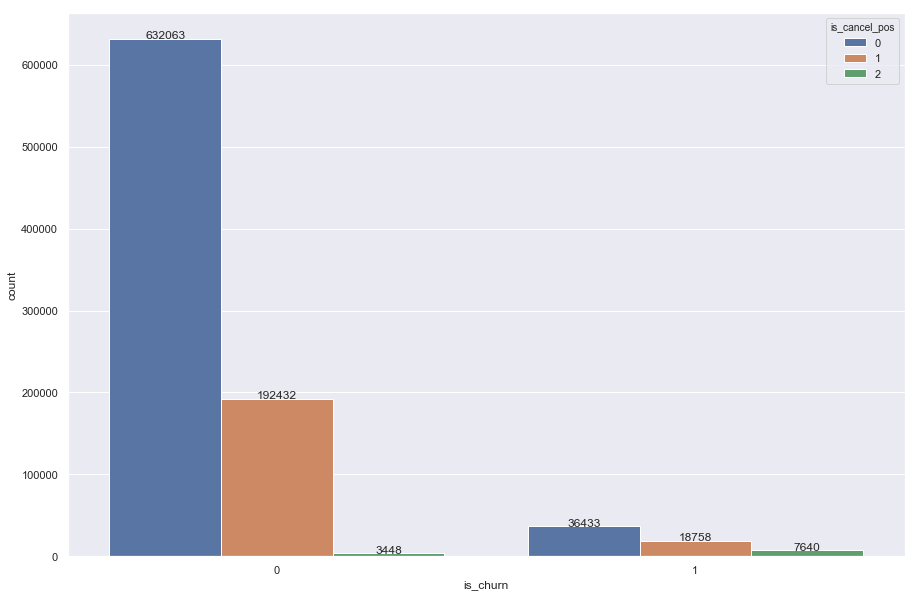

In [57]:
fig,axes = plt.subplots(figsize=(15,10))

ax=sns.countplot(x="is_churn", hue="is_cancel_pos", data=merged)
total = float(len(transactions))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2,height,'{:1d}'.format(height), ha="center") 

plt.show()

#### Timedelta features:

Created two new features:
+ No. of days the user has been a member
+ No. of days between last transaction and membership expire date

In [58]:
merged['membership_days']=merged.membership_expire_date - merged.registration_init_time
merged['days_bw_expire']=merged.membership_expire_date_last - merged.transaction_date_last 

In [59]:
merged.drop(['is_auto_renew','city','transaction_date','membership_expire_date','is_cancel','PriceDiff','membership_expire_date_last','transaction_date_last','bd','registration_init_time'], axis=1, inplace=True)


In [60]:
print("No. of instances after merging all the data together", len(merged))

No. of instances after merging all the data together 890774


In [61]:
len(merged.columns)

18

### User Logs

In [62]:
print("Total Number of instances: ",len(logs))

Total Number of instances:  5234111


In [63]:
logs.head()

,msno,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,+++FOrTS7ab3tIgIh8eWwX4FqRv8w/FoiOuyXsFvphY=,60,12,14,7,171,179,49996.771
1,+++dz9ZCWE2HB/47pJU82NJXQzQuZDx1Wm50YSk/kKk=,5,1,1,1,183,147,46731.474
2,++5IYGT7+CWMJ8hRsqoQLoaTXBLMJzlfK12eMTr9Ilw=,9,5,0,3,349,191,93902.890
3,++7jYuHyUSp41PyuttFx/MCepv7TdFQULgN8TxZULZk=,669,115,82,79,1790,2250,460357.686
4,++95tJZADNg8U8HKbYdxbbXIRsO6pw1zBK4tHI7BtZo=,1621,597,348,355,20961,15077,5295202.829


In [64]:
logs.isna().any()

msno          False
num_25        False
num_50        False
num_75        False
num_985       False
num_100       False
num_unq       False
total_secs    False
dtype: bool

No NaN values in logs

In [65]:
merged=merged.merge(logs,on='msno')

In [66]:
len(merged)

883230

One Hot Encoding the categorical features

In [67]:

cancel=pd.get_dummies(merged.is_cancel_pos, prefix='cancel_')
payment_method=pd.get_dummies(merged.payment_method_id, prefix='payment_method_')
plan_type=pd.get_dummies(merged.payment_plan_days, prefix='plan_type_')
gender=pd.get_dummies(merged.gender, prefix='gender_')
registered=pd.get_dummies(merged.registered_via, prefix='registered_via_')

final2=pd.concat([merged,cancel,payment_method,plan_type,gender,registered], axis=1)


In [68]:
final2.drop(['is_cancel_pos','payment_method_id','payment_plan_days','gender','registered_via'],axis=1,inplace=True)

Total_secs cannot be negative. Removing outliers in total_Secs:

In [69]:
final2.loc[(final2.total_secs<0),['total_secs']]=0


#### Univariate Analysis:

In [70]:
def create_kde(col):
    fig,axes = plt.subplots(figsize=(15,10))
    sns.kdeplot(final2[final2['is_churn'] == 1][col],label="churn = 1",shade=True)
    sns.kdeplot(final2[final2['is_churn'] == 0][col],label="churn = 0",shade=True)
    axes.set_xlabel('Value')
    axes.set_ylabel('Frequency') 
    axes.set_title(col)
    plt.show()

#### Total Seconds:

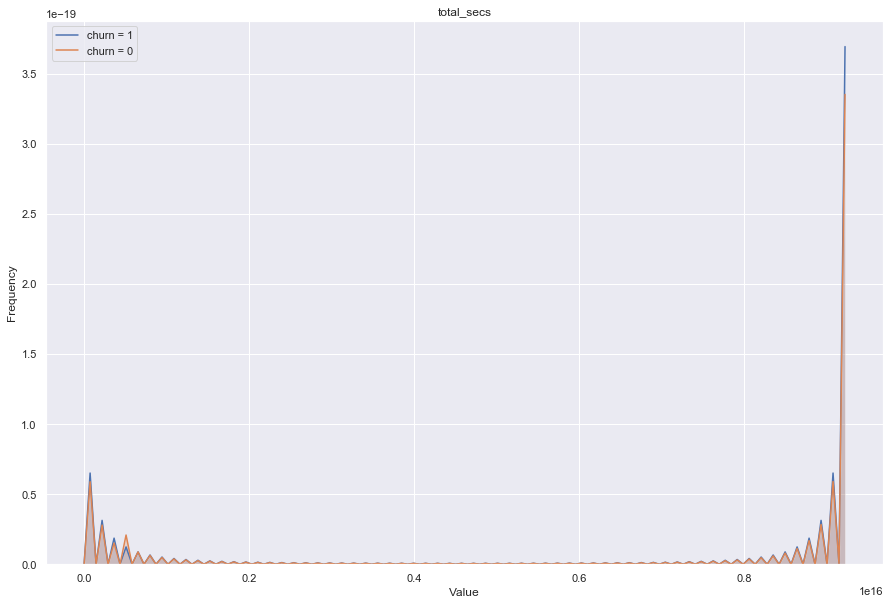

In [71]:
create_kde("total_secs")

#### Unique Songs:

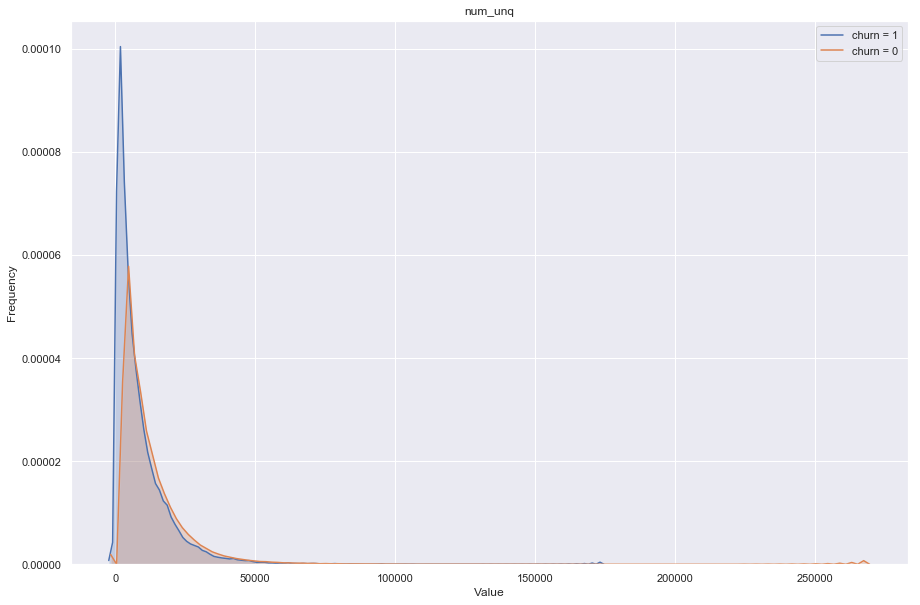

In [72]:
create_kde("num_unq")

#### Total Transactions:

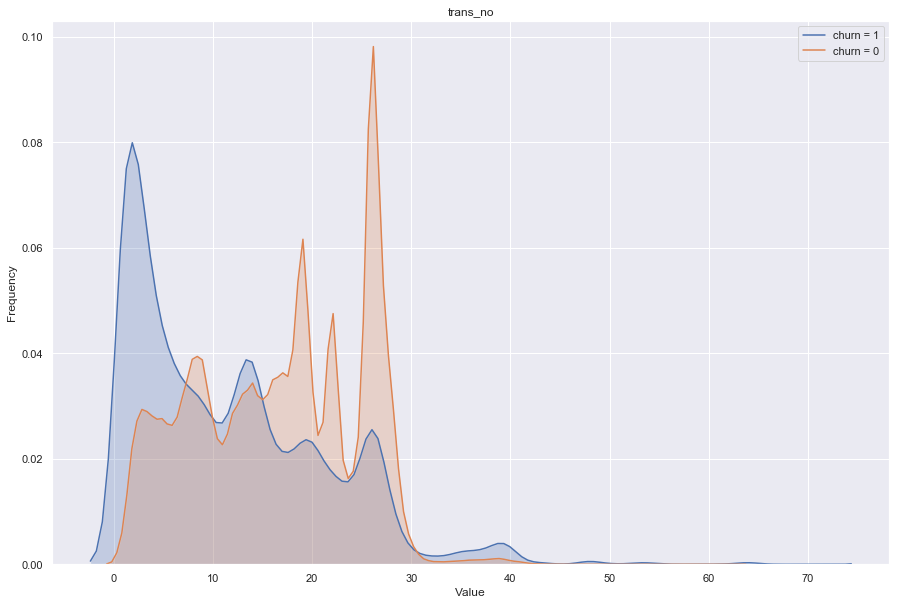

In [73]:
create_kde("trans_no")

May be customers who make more transactions, churn less.

#### 25% of Songs:

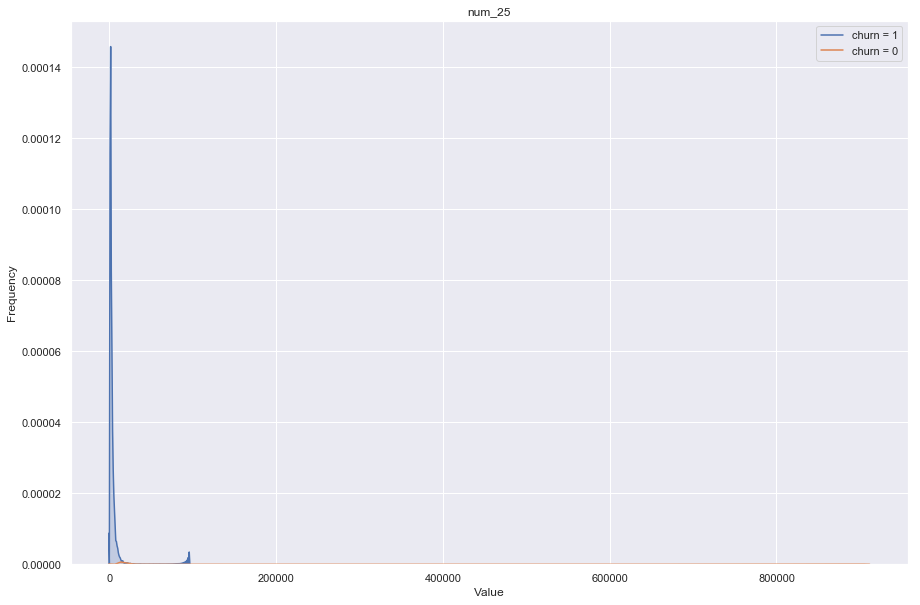

In [74]:
create_kde("num_25")

#### 50% of Song:

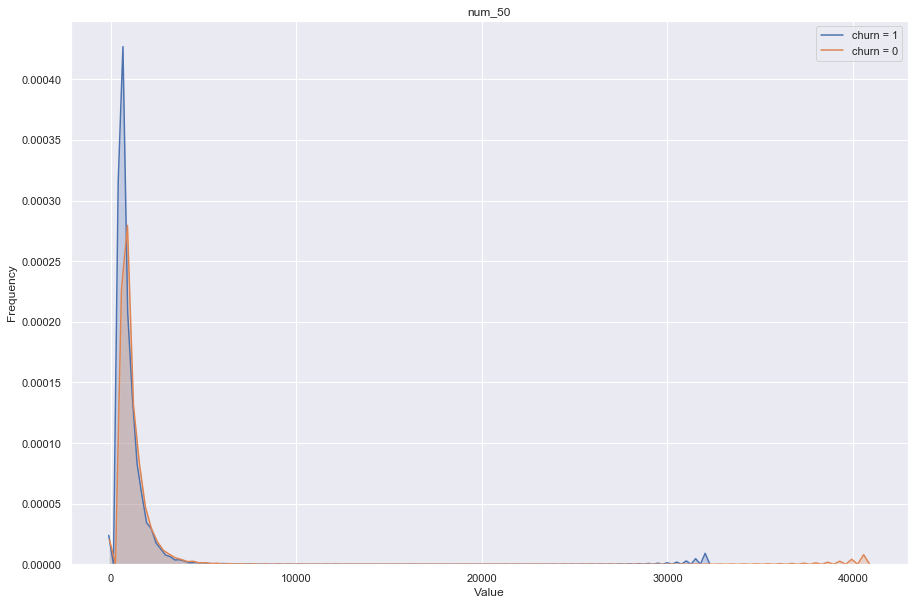

In [75]:
create_kde("num_50")

#### 75% of Song:

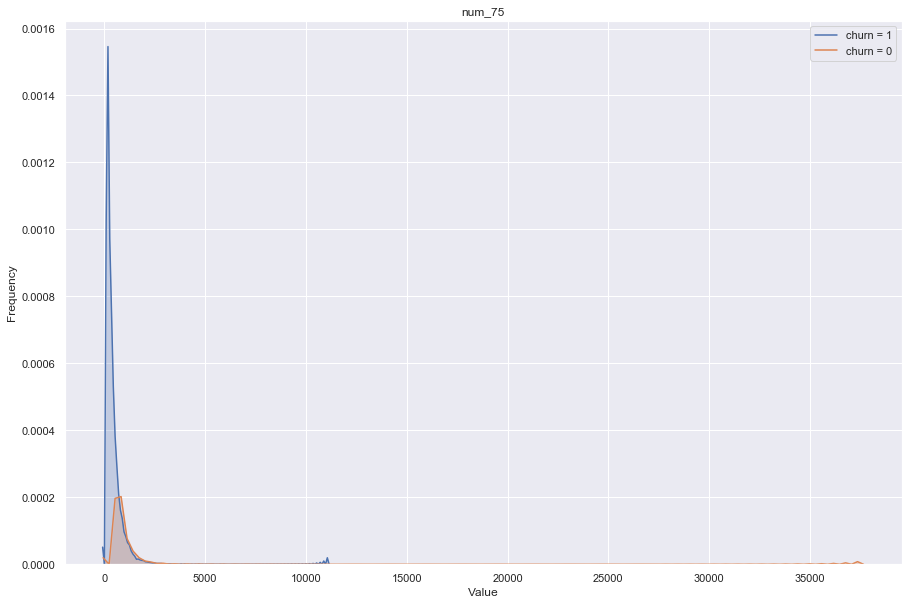

In [76]:
create_kde("num_75")

#### 98.5% of Song:

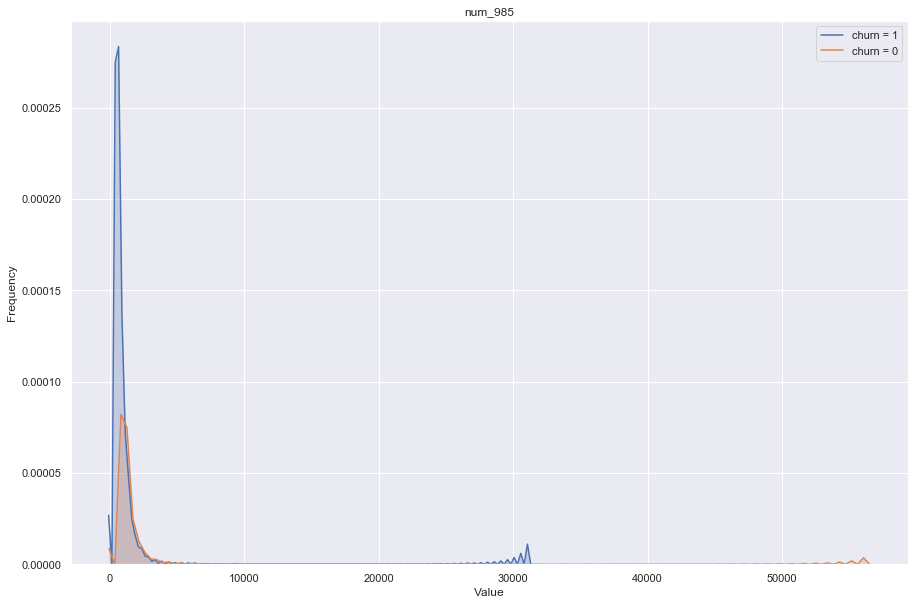

In [77]:
create_kde("num_985")

#### 100% of Song:

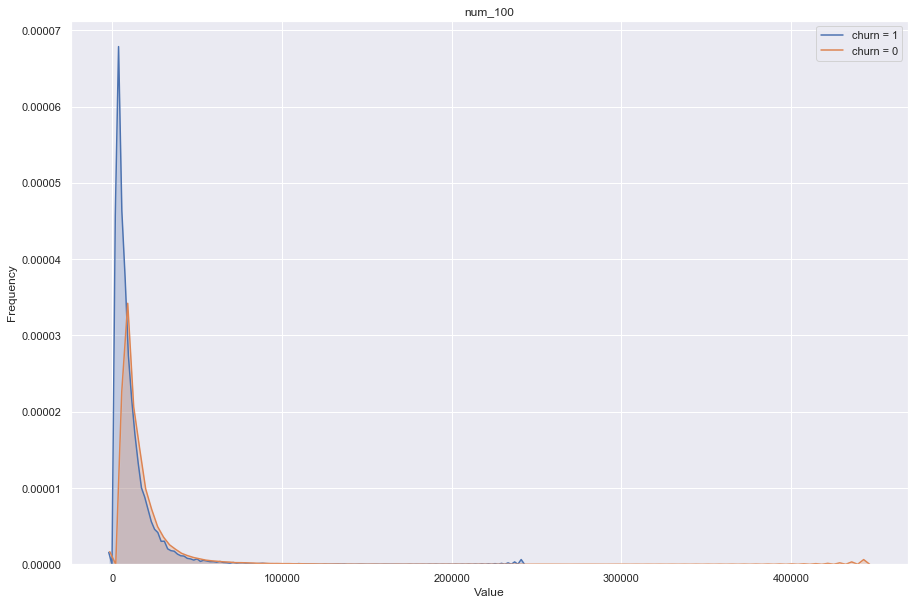

In [78]:
create_kde("num_100")

#### Total No. of auto_renews:

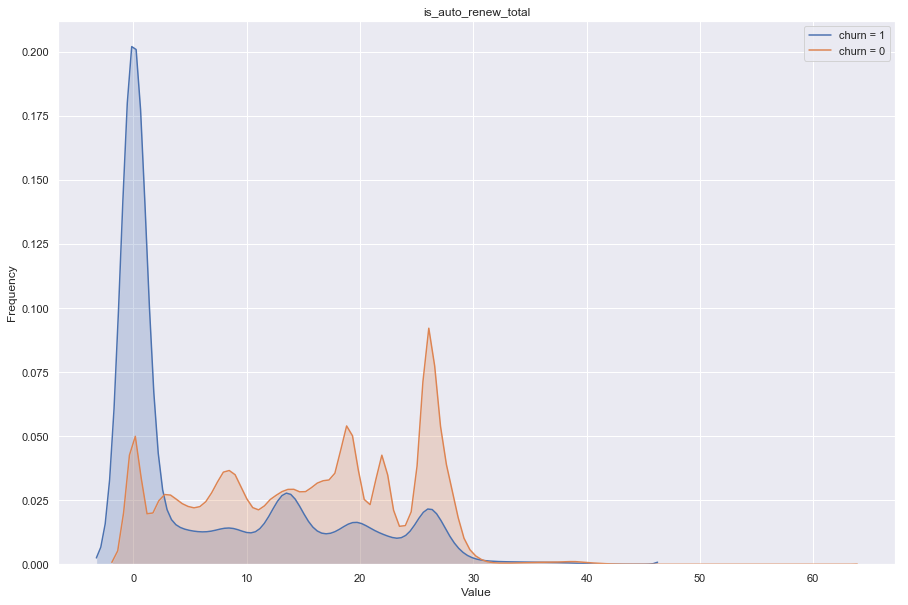

In [79]:
create_kde("is_auto_renew_total")

Customers who renew the subscription again, churn less

#### Total number of cancellations:

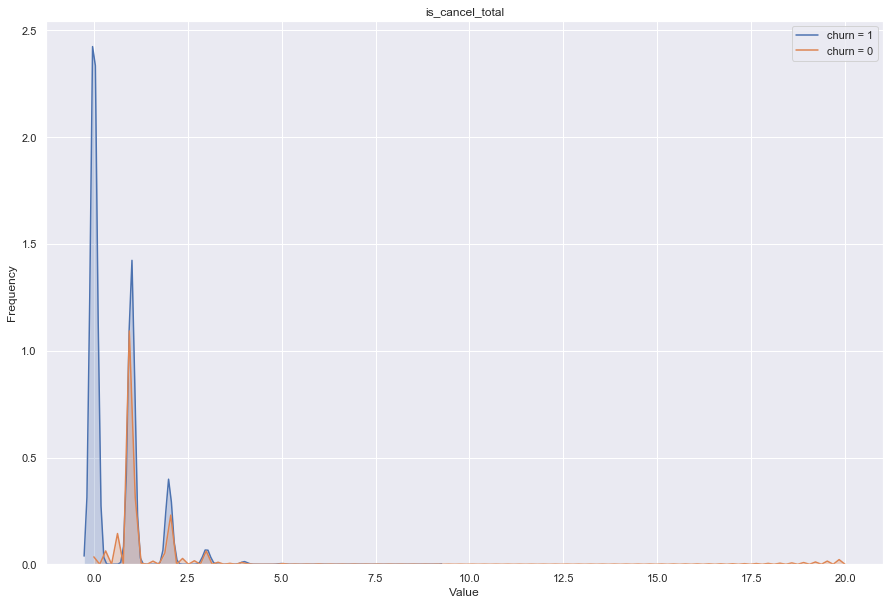

In [80]:
create_kde("is_cancel_total")

#### Total Number of Discounts:

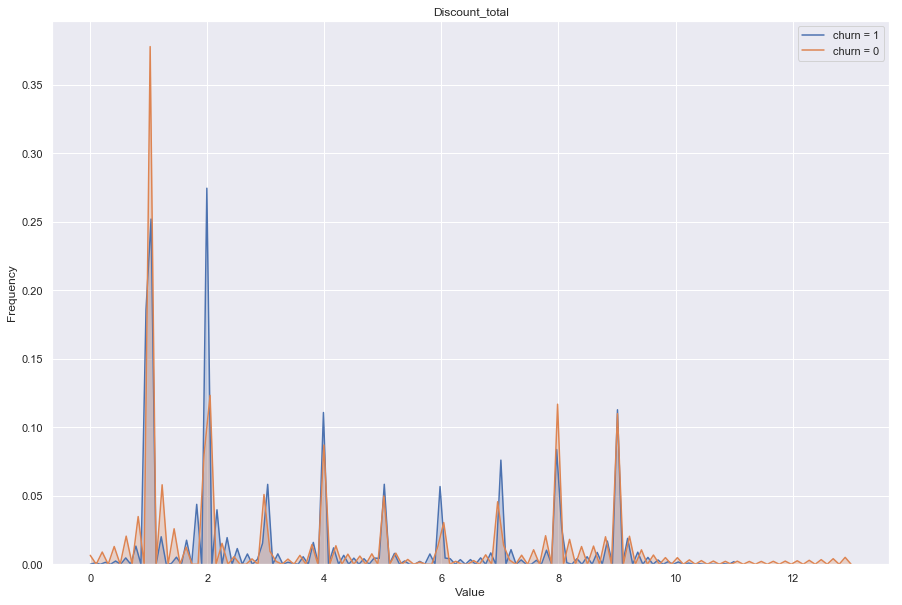

In [81]:
create_kde("Discount_total")

#### Total times the user paid extra:

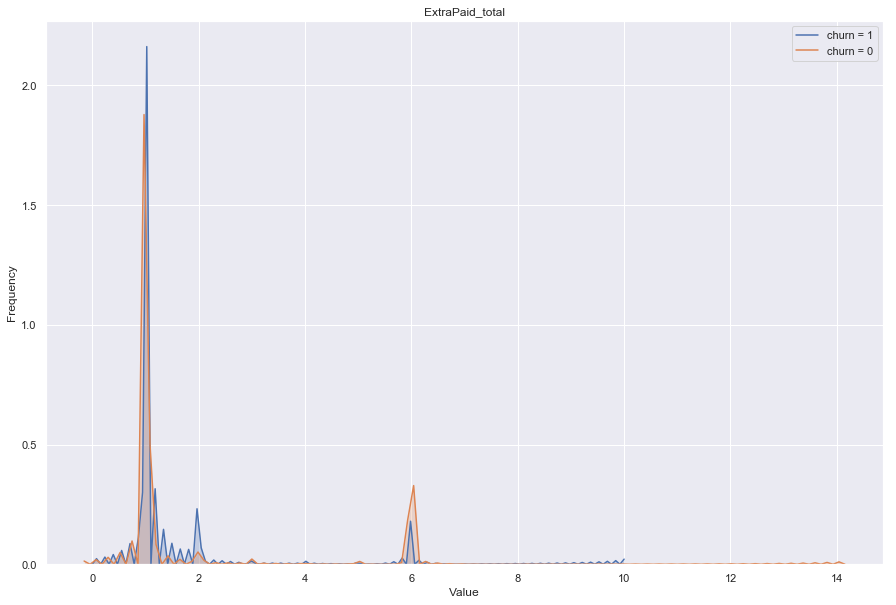

In [82]:
create_kde("ExtraPaid_total")

In [83]:
cols=['plan_list_price', 'actual_amount_paid', 'is_auto_renew_total', 'is_cancel_total', 'trans_no',
       'Discount_total', 'ExtraPaid_total','membership_days',
       'days_bw_expire', 'num_25', 'num_50', 'num_75', 'num_985', 'num_100',
       'num_unq', 'total_secs']

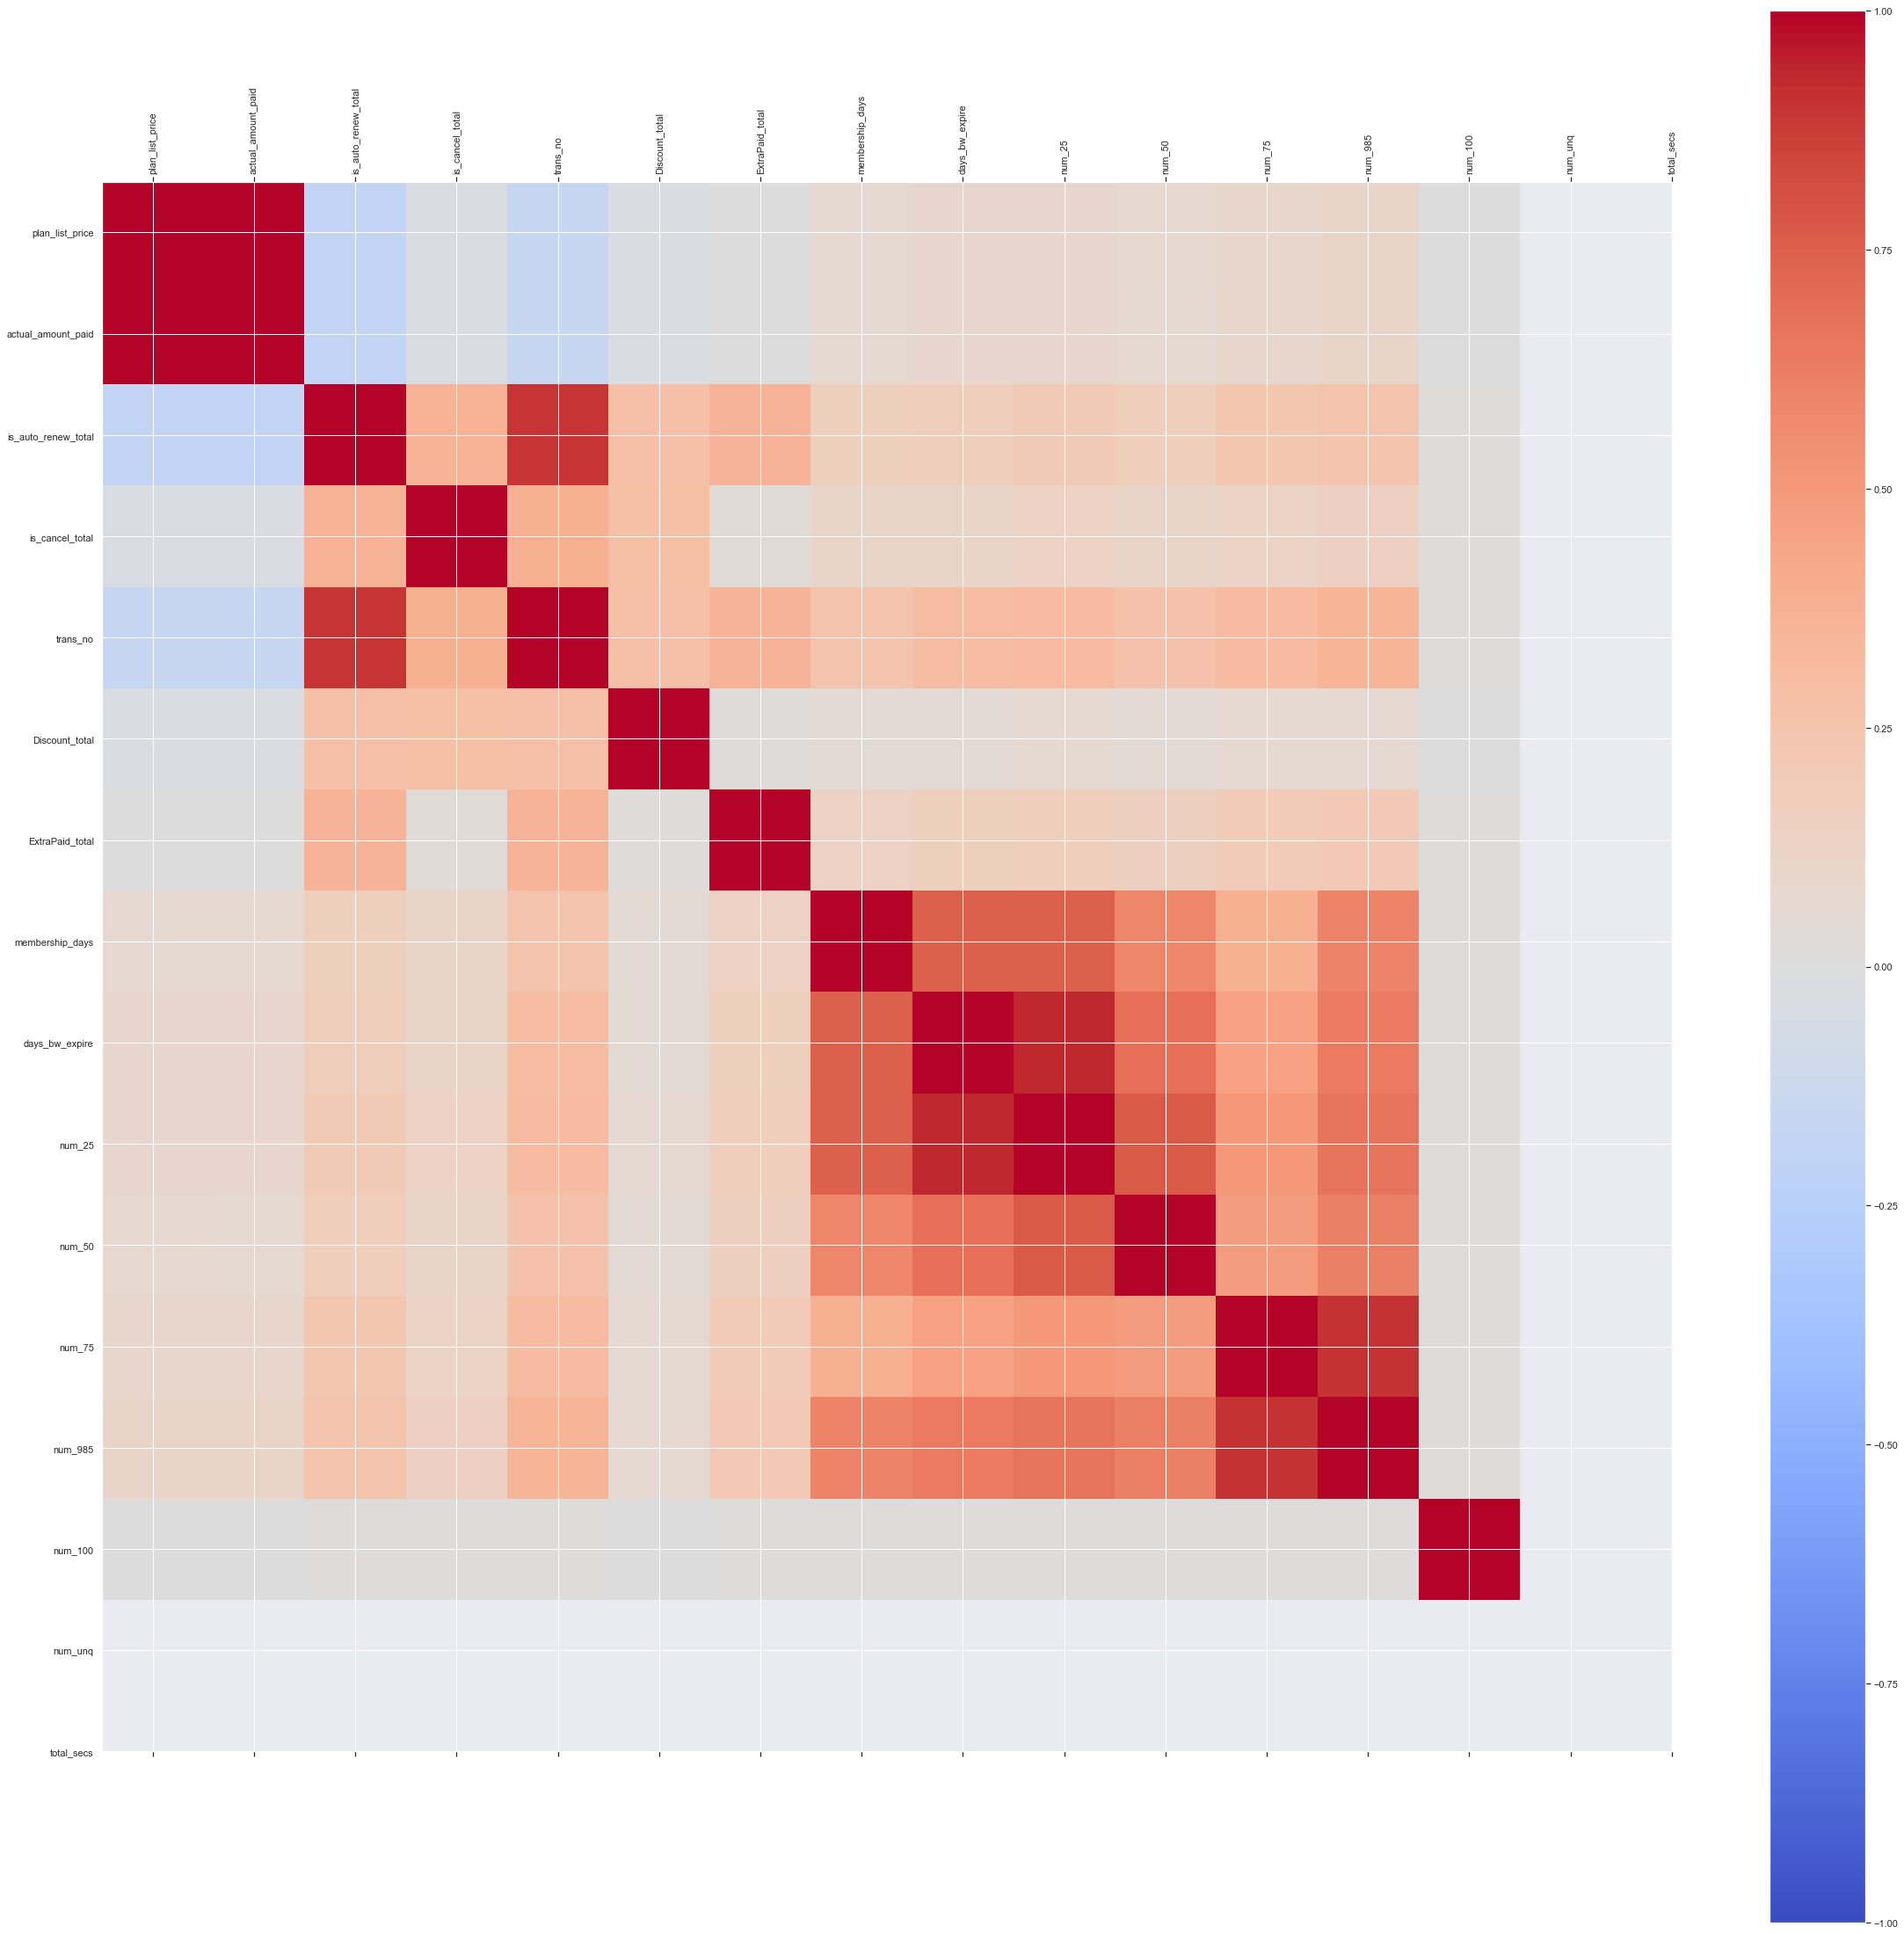

In [84]:
corr = final2[cols].corr()

fig,ax = plt.subplots(figsize=(40,40))
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(cols),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(cols)
ax.set_yticklabels(cols)
plt.show()

From the pearson correlation heatmap, we can see that the following are highly correlated:
+ plan_list_price and actual_Amount_paid
+ trans_no and is_auto_renewal_total
+ num_75 and num_985
+ num_25 and days_bw_expire
 
We should keep one from each group

------------------------------

In [85]:
final2.drop(['plan_list_price','num_25','is_auto_renew_total','num_985'],axis=1,inplace=True)

In [86]:
final2['membership_days'] = pd.to_numeric(final2.membership_days.dt.days)
final2['days_bw_expire'] = pd.to_numeric(final2.days_bw_expire.dt.days)

In [118]:
X = np.array(final2[['actual_amount_paid', 'Discount',
       'ExtraPaid', 'is_cancel_total', 'trans_no',
       'Discount_total', 'ExtraPaid_total', 'membership_days',
       'days_bw_expire', 'num_50', 'num_75', 'num_100',
       'num_unq', 'total_secs', 'cancel__0', 'cancel__1', 'cancel__2',
       'payment_method__3', 'payment_method__6', 'payment_method__8',
       'payment_method__10', 'payment_method__11', 'payment_method__12',
       'payment_method__13', 'payment_method__14', 'payment_method__15',
       'payment_method__16', 'payment_method__17', 'payment_method__18',
       'payment_method__19', 'payment_method__20', 'payment_method__21',
       'payment_method__22', 'payment_method__23', 'payment_method__26',
       'payment_method__27', 'payment_method__28', 'payment_method__29',
       'payment_method__30', 'payment_method__31', 'payment_method__32',
       'payment_method__33', 'payment_method__34', 'payment_method__35',
       'payment_method__36', 'payment_method__37', 'payment_method__38',
       'payment_method__39', 'payment_method__40', 'payment_method__41',
       'plan_type__0', 'plan_type__1', 'plan_type__2', 'plan_type__3',
       'plan_type__4', 'plan_type__5', 'gender__NT', 'gender__female',
       'gender__male', 'registered_via__3', 'registered_via__4',
       'registered_via__7', 'registered_via__9', 'registered_via__13']])
y = np.array(final2['is_churn'])

In [119]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

### Modelling:

---------------

As it is a imbalanced dataset, we need to take into account the precision as well as the recall. 

1. Logistice Regression:

In [134]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

In [121]:
dat_pipeline = Pipeline([
        ('std_scaler', StandardScaler()),
        ('pca_decom', PCA(0.95,random_state=42)),
        ('log_reg', LogisticRegression(random_state=42))
    ])

In [122]:
dat_pipeline.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('std_scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca_decom', PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=42,
  svd_solver='auto', tol=0.0, whiten=False)), ('log_reg', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [137]:
print("Train Accuracy",dat_pipeline.score(X_train,y_train)*100)

Train Accuracy 94.08407209900027


In [138]:
print("Test Accuracy",dat_pipeline.score(X_train,y_train)*100)

Test Accuracy 94.08407209900027


In [155]:
scal=StandardScaler()
X_test_log=scal.fit_transform(X_test)

In [156]:
y_pred_dat= dat_pipeline.predict(X_test_log)

In [157]:
from sklearn.metrics import roc_auc_score, roc_curve
print("Test Accuracy",roc_auc_score(y_test,y_pred_dat)*100)


Test Accuracy 62.97349842780078


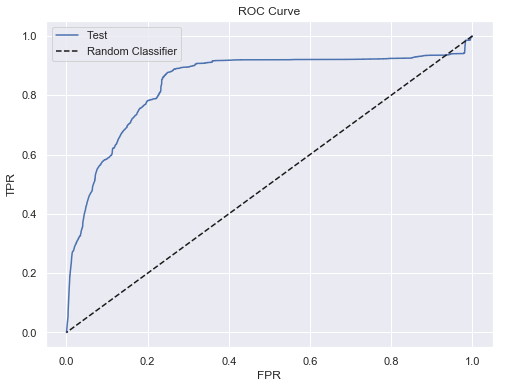

Test AUC: 0.6297349842780078


In [169]:
fpr, tpr, thresholds = roc_curve(y_test, dat_pipeline.predict_proba(X_test_log)[:,1], pos_label=1)
fpr2, tpr2, _ = roc_curve(y_train, dat_pipeline.predict_proba(X_train)[:,1], pos_label=1)
fig, axes = plt.subplots(figsize=(8,6))
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.plot(fpr,tpr, label="Test")
plt.plot([1,0],[1,0],'k--', label="Random Classifier")
plt.legend()

plt.show()
print("Test AUC:",roc_auc_score(y_test, y_pred_dat))


In [159]:
print(classification_report(y_test, y_pred_dat))

             precision    recall  f1-score   support

          0       0.95      0.98      0.96    164221
          1       0.55      0.28      0.37     12425

avg / total       0.92      0.93      0.92    176646



The recall is very low: 28%. Need to increase that as well as the auc_roc score

_________________________

2. Random Forest Classifier

Used Random Search to find the best parameters: 
+ 'random_state': 28
+ 'n_estimators': 4
+ 'min_samples_split': 4
+ 'max_features': 12
+ 'max_depth': 7
+ 'criterion': 'gini'
+ 'class_weight': 'balanced'
+ 'bootstrap': False

In [160]:
from sklearn.ensemble import RandomForestClassifier
rnd_cls = RandomForestClassifier()
rnd_cls.fit(X_train, y_train)
from sklearn.model_selection import RandomizedSearchCV
param_dist = {"n_estimators": range(1,30),
              "class_weight": ["balanced","balanced_subsample"],
              "max_depth": range(2,30),
              "max_features": range(1, 30),
              "min_samples_split": range(2, 20),
              "bootstrap": [True, False],
              "random_state": range(1,100),
              "criterion": ["gini", "entropy"]}
n_iter_search = 1
random_search = RandomizedSearchCV(rnd_cls, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=10)

In [162]:
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid=True, n_iter=1, n_jobs=1,
          param_distributions={'n_estimators': range(1, 30), 'class_weight': ['balanced', 'balanced_subsample'], 'max_depth': range(2, 30), 'max_features': range(1, 30), 'min_samples_split': range(2, 20), 'bootstrap': [True, False], 'random_state': range(1, 100), 'criterion': ['gini', 'entropy']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

First Random Forest Classifier:

In [168]:
rnd_cls_best = RandomForestClassifier(random_state= 31,
                                         class_weight = 'balanced_subsample',
                                         n_estimators= 25,
                                         min_samples_split= 5,
                                         max_features= 23,
                                         max_depth= 4,
                                         criterion= 'gini',
                                         bootstrap= True)

rnd_cls_best.fit(X_train, y_train)
y_pred_rnd = rnd_cls_best.predict(X_test)
rnd_cls_best.score(X_train,y_train)

0.9010648415475018

In [170]:
rnd_cls_best.score(X_test,y_test)

0.901679064343376

In [171]:
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(y_test, y_pred_rnd)
print(pd.DataFrame(cnf_matrix,columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))

     pred_neg  pred_pos
neg    148089     16132
pos      1236     11189


In [172]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_rnd))



             precision    recall  f1-score   support

          0       0.99      0.90      0.94    164221
          1       0.41      0.90      0.56     12425

avg / total       0.95      0.90      0.92    176646



In [99]:
from sklearn.metrics import roc_auc_score, f1_score
roc_auc_score(y_test,y_pred_rnd)

0.9226152089769298

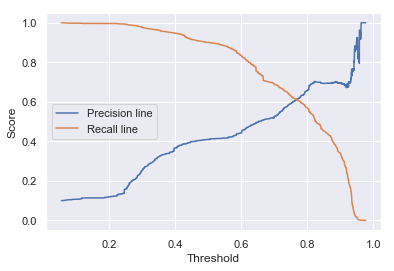

In [174]:
from sklearn.metrics import precision_recall_curve

y_test_prob = rnd_cls_best.predict_proba(X_test)
precision, recall, threshold = precision_recall_curve(y_test, y_test_prob[:, 1])
opt_threshold = threshold[np.where(np.sign(precision[:-1] - recall[:-1])==0)[0]]
plt.plot(threshold, precision[:-1], label = 'Precision line')
plt.plot(threshold, recall[:-1], label = 'Recall line')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend(loc = 'best')
plt.show()

for i in range(len(threshold)):
    if precision[i] == recall[i]:
        print("optimal probability cut point is: [%.3f, %.3f]" %(threshold[i], precision[i]))

We used random forest with randomized search and increased to recall from 28% to 90%.
The precision was 55% in logistic regression, and it decreased to 41% in random Forest. 
The f1 score increaded from 37% to 56%

In [177]:
X_plt= final2[['actual_amount_paid', 'Discount',
       'ExtraPaid', 'is_cancel_total', 'trans_no',
       'Discount_total', 'ExtraPaid_total', 'membership_days',
       'days_bw_expire', 'num_50', 'num_75', 'num_100',
       'num_unq', 'total_secs', 'cancel__0', 'cancel__1', 'cancel__2',
       'payment_method__3', 'payment_method__6', 'payment_method__8',
       'payment_method__10', 'payment_method__11', 'payment_method__12',
       'payment_method__13', 'payment_method__14', 'payment_method__15',
       'payment_method__16', 'payment_method__17', 'payment_method__18',
       'payment_method__19', 'payment_method__20', 'payment_method__21',
       'payment_method__22', 'payment_method__23', 'payment_method__26',
       'payment_method__27', 'payment_method__28', 'payment_method__29',
       'payment_method__30', 'payment_method__31', 'payment_method__32',
       'payment_method__33', 'payment_method__34', 'payment_method__35',
       'payment_method__36', 'payment_method__37', 'payment_method__38',
       'payment_method__39', 'payment_method__40', 'payment_method__41',
       'plan_type__0', 'plan_type__1', 'plan_type__2', 'plan_type__3',
       'plan_type__4', 'plan_type__5', 'gender__NT', 'gender__female',
       'gender__male', 'registered_via__3', 'registered_via__4',
       'registered_via__7', 'registered_via__9', 'registered_via__13']]
y_plt = final2['is_churn']

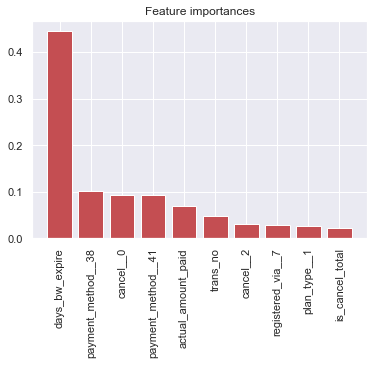

In [198]:
importances=rnd_cls_best.feature_importances_
indices = np.argsort(importances)[::-1]

ticks=[]
for f in range(10):
    ticks.append(str(X_plt.columns[indices[f]]))
    
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_plt.shape[1])[:10], importances[indices][:10], color="r",  align="center")
plt.xticks(range(X_plt.shape[1])[:10],ticks[:10], rotation='vertical')

plt.show()

_________________

3. Adaboost

In [199]:
from sklearn.ensemble import AdaBoostClassifier
model_ad = AdaBoostClassifier()
model_ad.fit(X_train , y_train)
y_pred = model_ad.predict(X_test)
print(classification_report(y_test,y_pred))

             precision    recall  f1-score   support

          0       0.96      0.98      0.97    164221
          1       0.69      0.47      0.56     12425

avg / total       0.94      0.95      0.94    176646



In [200]:
model_ad.score(X_test, y_test)

0.9478448422268265

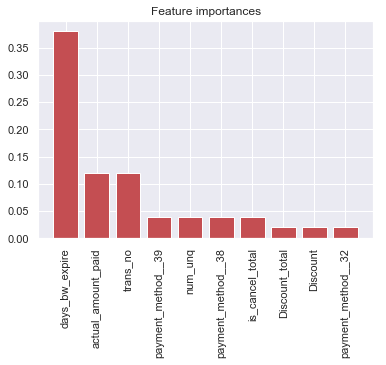

In [201]:
importances=model_ad.feature_importances_
indices = np.argsort(importances)[::-1]

ticks=[]
for f in range(10):
    ticks.append(str(X_plt.columns[indices[f]]))
    
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_plt.shape[1])[:10], importances[indices][:10], color="r",  align="center")
plt.xticks(range(X_plt.shape[1])[:10],ticks[:10], rotation='vertical')

plt.show()

_____________________

4. XGBoost

In [203]:
import xgboost as xgb
xg_cls = xgb.XGBClassifier(learning_rate=0.1, n_estimators=140, max_depth=5,
                        min_child_weight=3, gamma=0.2, subsample=0.6, colsample_bytree=1.0,
                        objective='binary:logistic', nthread=4, scale_pos_weight=1, seed=27)

In [204]:
xg_cls.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1.0, gamma=0.2, learning_rate=0.1,
       max_delta_step=0, max_depth=5, min_child_weight=3, missing=None,
       n_estimators=140, n_jobs=1, nthread=4, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=27, silent=True, subsample=0.6)

In [205]:
y_pred_xgb = xg_cls.predict(X_test)

C:\Users\varda\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [206]:
print(classification_report(y_test,y_pred_xgb))

             precision    recall  f1-score   support

          0       0.97      0.99      0.98    164221
          1       0.76      0.60      0.67     12425

avg / total       0.96      0.96      0.96    176646



In [207]:
roc_auc_score(y_test,y_pred_xgb)

0.7926890684446832

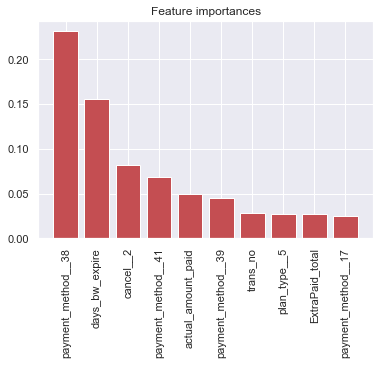

In [208]:
importances=xg_cls.feature_importances_
indices = np.argsort(importances)[::-1]

ticks=[]
for f in range(10):
    ticks.append(str(X_plt.columns[indices[f]]))
    
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_plt.shape[1])[:10], importances[indices][:10], color="r",  align="center")
plt.xticks(range(X_plt.shape[1])[:10],ticks[:10], rotation='vertical')

plt.show()

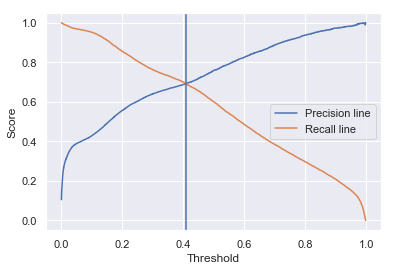

optimal probability cut point is: [0.409, 0.692]


In [209]:
from sklearn.metrics import precision_recall_curve

y_test_prob = xg_cls.predict_proba(X_test)
precision, recall, threshold = precision_recall_curve(y_test, y_test_prob[:, 1])
opt_threshold = threshold[np.where(np.sign(precision[:-1] - recall[:-1])==0)[0]]
plt.plot(threshold, precision[:-1], label = 'Precision line')
plt.plot(threshold, recall[:-1], label = 'Recall line')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.axvline(opt_threshold)
plt.legend(loc = 'best')
plt.show()

for i in range(len(threshold)):
    if precision[i] == recall[i]:
        print("optimal probability cut point is: [%.3f, %.3f]" %(threshold[i], precision[i]))

## Conclusion

We would recommend XGBoost model for KKBox Inc. for the following reason:
XGBoost has decent recall (60%) with high precision (76%) which would be better from the business perspective as the people that the model is identifying as churned, it predicts 76% of them correctly which is a reasonable choice


## Future Work

+ Creating a model that improves recall while keeping a stable precision.

+ Time series analysis

+ Getting more data on the genre of songs members watch to build a profile and get insights specific to members who churn.

+ Combining model with kkbox’s survival analysis.
